In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,ZeroPadding2D
#from keras.optimizers import SGD
#from keras import applications
#from keras.models import Model
import cv2
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from tqdm import tqdm

In [2]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [3]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-02-27 11:34:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.2.72.163, 2600:1407:a800:588::317f, 2600:1407:a800:591::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.2.72.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   197MB/s    in 4.1s    

2023-02-27 11:34:57 (193 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [4]:
import os
import zipfile

local_zip = '/content/kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
!nvidia-smi

Mon Feb 27 11:36:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
cat_path= '/content/PetImages/Cat'
dog_path= '/content/PetImages/Dog'

In [7]:
IMG_SIZE=227
labels=[]

In [8]:
def image_read(TRAIN_DIR):
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        if img is not None:
          img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
          img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
          training_data.append(np.array(img))
    return training_data

In [9]:
def labelss(data,class_value):
  y=np.ones(len(data),dtype=int)*class_value
  return y

In [10]:
cat_path

'/content/PetImages/Cat'

In [11]:
cat_data=image_read(cat_path)

100%|██████████| 12501/12501 [00:28<00:00, 433.70it/s]


In [12]:
import matplotlib.pyplot as plt

In [13]:
np.shape(cat_data)

(12476, 227, 227, 3)

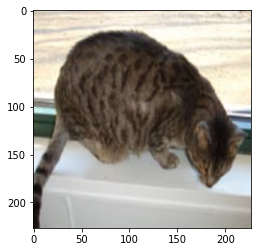

In [14]:
plt.imshow(cat_data[11])

In [15]:
cat_label=labelss(cat_data,1)

In [16]:
cat_label.shape

(12476,)

In [17]:
dog_data=image_read(dog_path)

100%|██████████| 12501/12501 [00:30<00:00, 404.19it/s]


In [18]:
class_dog=labelss(dog_data,0)

In [19]:
class_dog.shape

(12470,)

In [20]:
dataset=np.concatenate((dog_data,cat_data))

In [21]:
dataset.shape

(24946, 227, 227, 3)

In [22]:
class_labels=np.concatenate((class_dog,cat_label))

In [23]:
class_labels.shape

(24946,)

In [24]:
del dog_data, cat_data

In [25]:
import sklearn.model_selection as ms

In [26]:
x_train,x_test,y_train,y_test=ms.train_test_split(dataset,class_labels,test_size=0.3,random_state=121123451)

In [27]:
x_train.shape,x_test.shape

((17462, 227, 227, 3), (7484, 227, 227, 3))

In [28]:
from tensorflow.keras.utils import to_categorical
y_train_onehot= to_categorical(y_train)
y_test_onehot=to_categorical(y_test)

In [29]:
y_train_onehot.shape

(17462, 2)

In [30]:
# Initialize model
alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(96, (11, 11), input_shape=(227,227,3), padding='same'))
alexnet.add(BatchNormalization())
conv1=Activation('relu')
alexnet.add(conv1) 
max_pool_1=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_1)

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
conv2=Activation('relu')
alexnet.add(conv2)
max_pool_2=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_2)

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
max_pool_5=MaxPooling2D(pool_size=(2, 2))
alexnet.add(max_pool_5)

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(512))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(512))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(2))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

In [31]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 227, 227, 96)     384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 227, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 96)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 256)     614656    
                                                                 
 batch_normalization_1 (Batc  (None, 113, 113, 256)    1

In [32]:
alexnet.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [1]:
history=alexnet.fit(x_train[0:1000], y_train_onehot[0:1000], batch_size=8, epochs=20, validation_split=0.1, shuffle=True)

NameError: ignored

In [ ]:
alexnet.save('cat_dog.h5')

In [ ]:
alexnet.predict(x_test[12].reshape(1,227,227,3))

NameError: ignored

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

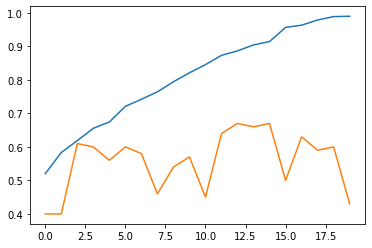

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
img_to_visualize =x_test[99]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

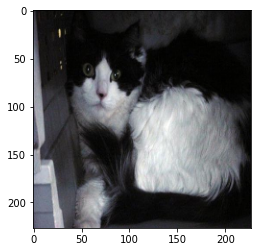

In [ ]:
plt.imshow(x_test[99])

In [ ]:
from keras import backend as K
import math

def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 33, 33, 1024)  min: -45.57311248779297  max: 58.99106216430664


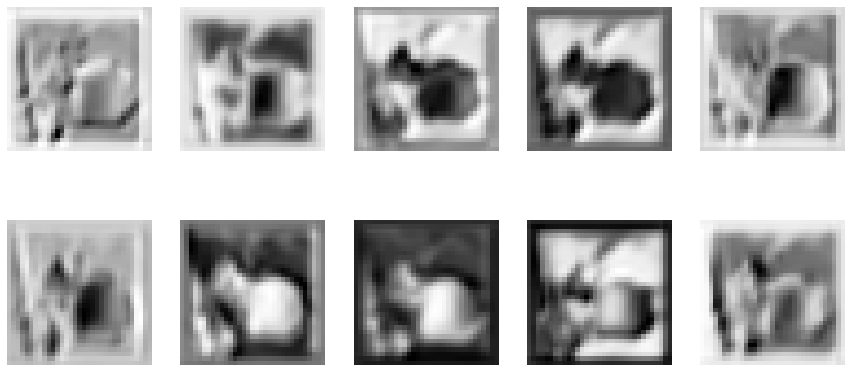

In [ ]:
view_layer(alexnet, img_to_visualize , "conv2d_4")

In [ ]:
test_sai = cv2.imread('/content/krishna_mouli.jpg')
test_sai = cv2.resize(test_sai, (IMG_SIZE,IMG_SIZE))
test_sai = cv2.cvtColor(test_sai,cv2.COLOR_BGR2RGB)

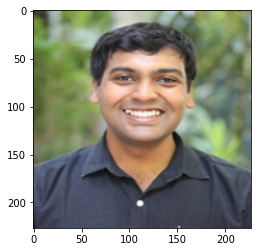

In [ ]:
plt.imshow(test_sai)

In [ ]:
alexnet.predict(test_sai.reshape(1,227,227,3))

array([[0.96508026, 0.03491972]], dtype=float32)

## Assignment
Task 1: Select one of the image data preprocessing Technique A.K.A Normalization, Image Whitening Etc. and measure the model performance. 

#### DO THIS AT HOME
